[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Testing (0, 0, 0) x (0, 0, 0, 12) - R2: 0.6157004641685027
Testing (0, 0, 0) x (0, 0, 1, 12) - R2: 0.6176545913984269
Testing (0, 0, 0) x (0, 1, 0, 12) - R2: 0.6803700548651447
Testing (0, 0, 0) x (0, 1, 1, 12) - R2: 0.7495761680340014
Testing (0, 0, 0) x (1, 0, 0, 12) - R2: 0.6183525239910741
Testing (0, 0, 0) x (1, 0, 1, 12) - R2: 0.61796502162711
Testing (0, 0, 0) x (1, 1, 0, 12) - R2: 0.7325112711420698
Testing (0, 0, 0) x (1, 1, 1, 12) - R2: 0.7445106231607801
Testing (0, 0, 1) x (0, 0, 0, 12) - R2: 0.6157453187645096
Testing (0, 0, 1) x (0, 0, 1, 12) - R2: 0.6173489400239554
Testing (0, 0, 1) x (0, 1, 0, 12) - R2: 0.6764764153341629
Testing (0, 0, 1) x (0, 1, 1, 12) - R2: 0.7461640283558967
Testing (0, 0, 1) x (1, 0, 0, 12) - R2: 0.618188700519249
Testing (0, 0, 1) x (1, 0, 1, 12) - R2: 0.6178969868600075
Testing (0, 0, 1) x (1, 1, 0, 12) - R2: 0.7292764114481599
Testing (0, 0, 1) x (1, 1, 1, 12) - R2: 0.7436054716075755
Testing (0, 1, 0) x (0, 0, 0, 12) - R2: 0.15530989779835971

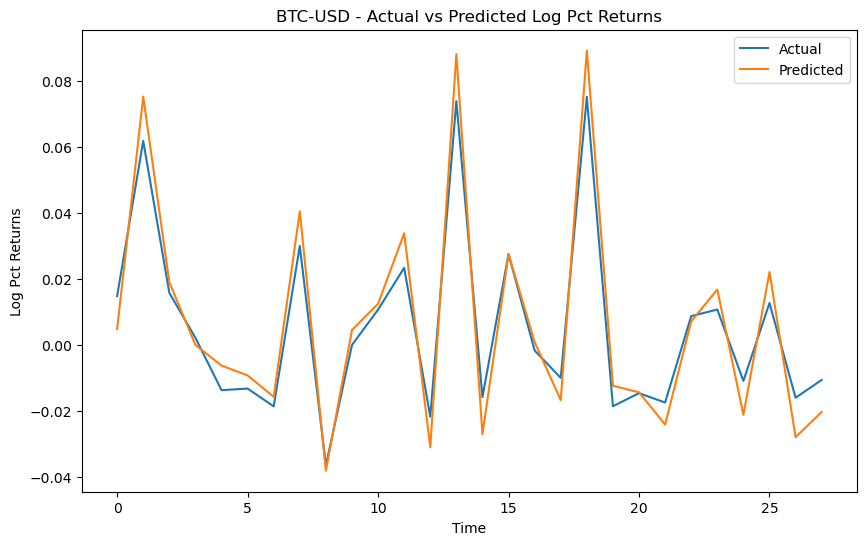

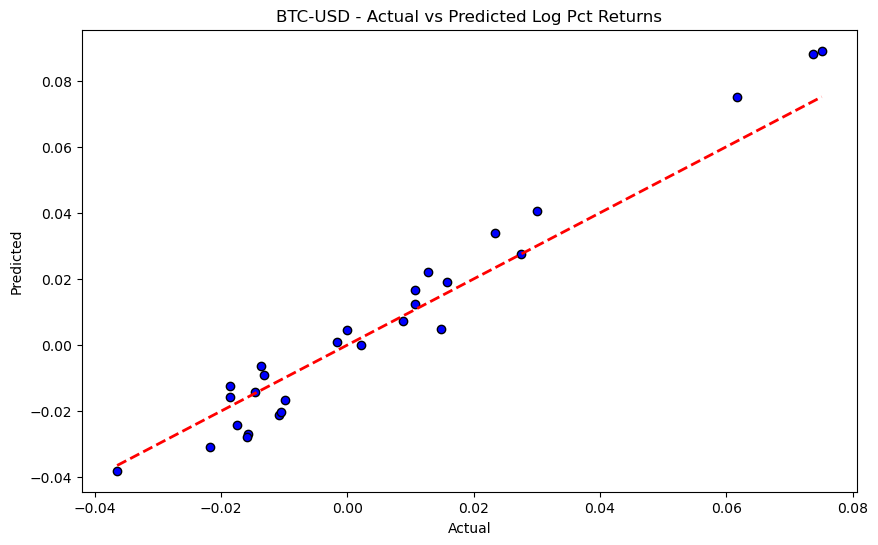

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Define the start and end dates for data download
end_date = datetime(2024, 5, 31)
start_date = datetime(2023, 6, 1)

# Download stock price data from Yahoo Finance using ticker 'BTC-USD'
ticker = 'BTC-USD'
data_btc = yf.download(tickers=ticker, start=start_date, end=end_date)
df_btc = pd.DataFrame(data_btc)
df_btc.reset_index(inplace=True)
df_btc.set_index('Date', inplace=True)

# Download gold prices and US Dollar index data from Yahoo Finance
tick_gold = 'GC=F'
tick_usindex = 'DX-Y.NYB'
data_gold = yf.download(tickers=tick_gold, start=start_date, end=end_date)
data_usindex = yf.download(tickers=tick_usindex, start=start_date, end=end_date)

# Convert downloaded data into dataframes
df_gold = pd.DataFrame(data_gold)
df_usindex = pd.DataFrame(data_usindex)

# Add adjusted close prices for gold and US Dollar index to the Bitcoin dataframe
df_btc['Gold_Adj_Close'] = df_gold['Adj Close']
df_btc['USIndex_Adj_Close'] = df_usindex['Adj Close']
df_btc.ffill(inplace=True)

# Calculate additional features for the Bitcoin dataframe
df_btc['Open_Close_Diff'] = df_btc['Open'] - df_btc['Adj Close']
df_btc['High_Low_Diff'] = df_btc['High'] - df_btc['Low']
df_btc['Pct_Returns'] = df_btc['Adj Close'].pct_change()
df_btc['Log_Pct_Returns'] = np.log(1 + df_btc['Pct_Returns'])
df_btc.dropna(inplace=True)

# Moving Averages
df_btc['SMA_5'] = df_btc['Adj Close'].rolling(window=5).mean()
df_btc['SMA_10'] = df_btc['Adj Close'].rolling(window=10).mean()
df_btc['SMA_20'] = df_btc['Adj Close'].rolling(window=20).mean()
df_btc['SMA_50'] = df_btc['Adj Close'].rolling(window=50).mean()
df_btc['EMA_50'] = df_btc['Adj Close'].ewm(span=50, adjust=False).mean()

# Relative Strength Index (RSI)
window_length = 14
delta = df_btc['Adj Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=window_length).mean()
loss = (delta.where(delta < 0, 0)).rolling(window=window_length).mean()
rs = gain / loss
df_btc['RSI'] = 100 - (100 / (1 + rs))

# Moving Average Convergence Divergence (MACD)
df_btc['MACD'] = df_btc['Adj Close'].ewm(span=12, adjust=False).mean() - df_btc['Adj Close'].ewm(span=26, adjust=False).mean()
df_btc['MACD_Signal'] = df_btc['MACD'].ewm(span=9, adjust=False).mean()
df_btc['MACD_Hist'] = df_btc['MACD'] - df_btc['MACD_Signal']

# Bollinger Bands
df_btc['BB_Upper'] = df_btc['SMA_20'] + 2 * df_btc['Adj Close'].rolling(window=20).std()
df_btc['BB_Lower'] = df_btc['SMA_20'] - 2 * df_btc['Adj Close'].rolling(window=20).std()

# Stochastic Oscillator
df_btc['14-high'] = df_btc['High'].rolling(14).max()
df_btc['14-low'] = df_btc['Low'].rolling(14).min()
df_btc['%K'] = (df_btc['Adj Close'] - df_btc['14-low']) * 100 / (df_btc['14-high'] - df_btc['14-low'])
df_btc['%D'] = df_btc['%K'].rolling(3).mean()

# Average True Range (ATR)
df_btc['H-L'] = df_btc['High'] - df_btc['Low']
df_btc['H-PC'] = np.abs(df_btc['High'] - df_btc['Adj Close'].shift(1))
df_btc['L-PC'] = np.abs(df_btc['Low'] - df_btc['Adj Close'].shift(1))
df_btc['TR'] = df_btc[['H-L', 'H-PC', 'L-PC']].max(axis=1)
df_btc['ATR'] = df_btc['TR'].rolling(14).mean()

# Shift columns to create lagged features
columns_to_shift = [
    'Open', 'High', 'Adj Close', 'Low', 'Volume',
    'Open_Close_Diff', 'High_Low_Diff',
    'Gold_Adj_Close', 'USIndex_Adj_Close',
    'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_50',
    'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist', 'BB_Upper', 'BB_Lower',
    '%K', '%D', 'ATR'
]

num_lags = 3

for column in columns_to_shift:
    for lag in range(1, num_lags + 1):
        df_btc[f'{column}_{lag}'] = df_btc[column].shift(lag)

df_btc['Pct_Returns_1'] = df_btc['Pct_Returns'].shift(1)
df_btc['Log_Pct_Returns_1'] = df_btc['Log_Pct_Returns'].shift(1)
df_btc.dropna(inplace=True)

# Download and process economic indicators
def fetch_and_preprocess_economic_data():
    # Fetch economic indicators data from FRED
    economic_indicators = {
        'T5YIE': 'Inflation',
        'FEDFUNDS': 'FedFunds',
        'GDPC1': 'GDP',
        'UNRATE': 'Unemployment',
        'UMCSENT': 'ConsumerSentiment',
        'CPILFESL': 'CoreCPI',
        'PPIACO': 'CommodityPrices',
        'WM2NS': 'M2MoneySupply'
    }
    
    dfs_economic = {}
    
    for code, name in economic_indicators.items():
        df = pdr.get_data_fred(code, start=start_date, end=end_date)
        df = df.resample('D').ffill().dropna()
        df.columns = [name]
        dfs_economic[name] = df
    
    return dfs_economic

dfs_economic = fetch_and_preprocess_economic_data()

# Merge economic data into the Bitcoin dataframe
for econ_name, econ_df in dfs_economic.items():
    df_btc[econ_name] = econ_df[econ_name]

# Define the features and target variable
features = ['Volume_1', 'Open_1', 'High_1', 'Low_1','Adj Close_1',
            'Open_Close_Diff_1','High_Low_Diff_1', 'USIndex_Adj_Close_1',
            'Open_2', 'High_2', 'Low_2','Adj Close_2',
            'Open_Close_Diff_2','USIndex_Adj_Close_2',
            'Open_3',  'Low_3',
            'USIndex_Adj_Close_3',
            'SMA_5_1', 'SMA_10_1', 'SMA_20_1',
            'EMA_50_1', 'MACD_1', 'MACD_Signal_1',
            'MACD_Hist_1', 'BB_Upper_1',  '%K_1', '%D_1','ATR_1',
            'SMA_5_2', 'SMA_10_2', 'SMA_50_2',
            'MACD_2',
            'MACD_Hist_2', 'BB_Upper_2', 'BB_Lower_2', '%K_2', '%D_2', 'ATR_2'
            ]
X = df_btc[features].dropna()
y = df_btc['Log_Pct_Returns_1'][X.index]

# Apply MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)

# Define parameter grid for hyperparameter tuning
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in itertools.product(p, d, q)]

# Perform grid search to find the best hyperparameters based on R2 score
best_r2 = float('-inf')
best_params = None
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            r2_scores = []
            for train_index, test_index in tscv.split(X_scaled):
                X_train, X_test = X_scaled[train_index], X_scaled[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]

                model = SARIMAX(y_train, exog=X_train, order=param, seasonal_order=param_seasonal)
                model_fit = model.fit(disp=False)
                y_pred = model_fit.predict(start=test_index[0], end=test_index[-1], exog=X_test)
                r2 = r2_score(y_test, y_pred)
                r2_scores.append(r2)

            avg_r2 = np.mean(r2_scores)
            print(f"Testing {param} x {param_seasonal} - R2: {avg_r2}")  # Debug output
            if avg_r2 > best_r2:
                best_r2 = avg_r2
                best_params = (param, param_seasonal)
        except Exception as e:
            print(f"Failed to fit model with parameters {param} x {param_seasonal}: {e}")  # Error feedback

print(f'Best SARIMAX configuration: {best_params} with R2: {best_r2}')

# Perform cross-validation with the best SARIMAX configuration
if best_params is not None:
    train_mse_scores = []
    test_mse_scores = []
    train_rmse_scores = []
    test_rmse_scores = []
    train_mae_scores = []
    test_mae_scores = []
    train_r2_scores = []
    test_r2_scores = []

    for train_index, test_index in tscv.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit SARIMAX model with the best parameters
        model = SARIMAX(y_train, exog=X_train, order=best_params[0], seasonal_order=best_params[1])
        model_fit = model.fit(disp=False)

        # Predict on the test set
        y_train_pred = model_fit.predict(start=train_index[0], end=train_index[-1], exog=X_train)
        y_test_pred = model_fit.predict(start=test_index[0], end=test_index[-1], exog=X_test)

        # Calculate performance metrics
        train_mse = mean_squared_error(y_train, y_train_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)
        train_rmse = np.sqrt(train_mse)
        test_rmse = np.sqrt(test_mse)
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)

        # Append metrics to lists
        train_mse_scores.append(train_mse)
        test_mse_scores.append(test_mse)
        train_rmse_scores.append(train_rmse)
        test_rmse_scores.append(test_rmse)
        train_mae_scores.append(train_mae)
        test_mae_scores.append(test_mae)
        train_r2_scores.append(train_r2)
        test_r2_scores.append(test_r2)

    # Calculate mean and standard deviation of the scores
    mean_train_mse = np.mean(train_mse_scores)
    std_train_mse = np.std(train_mse_scores)
    mean_test_mse = np.mean(test_mse_scores)
    std_test_mse = np.std(test_mse_scores)
    mean_train_rmse = np.mean(train_rmse_scores)
    std_train_rmse = np.std(train_rmse_scores)
    mean_test_rmse = np.mean(test_rmse_scores)
    std_test_rmse = np.std(test_rmse_scores)
    mean_train_mae = np.mean(train_mae_scores)
    std_train_mae = np.std(train_mae_scores)
    mean_test_mae = np.mean(test_mae_scores)
    std_test_mae = np.std(test_mae_scores)
    mean_train_r2 = np.mean(train_r2_scores)
    std_train_r2 = np.std(train_r2_scores)
    mean_test_r2 = np.mean(test_r2_scores)
    std_test_r2 = np.std(test_r2_scores)

    # Print Results
    print("BTC-USD - Training MSE: {:.4f}".format(mean_train_mse))
    print("BTC-USD - Training MSE Std Dev: {:.4f}".format(std_train_mse))
    print("BTC-USD - Test MSE: {:.4f}".format(mean_test_mse))
    print("BTC-USD - Test MSE Std Dev: {:.4f}".format(std_test_mse))
    print("BTC-USD - Training RMSE: {:.4f}".format(mean_train_rmse))
    print("BTC-USD - Training RMSE Std Dev: {:.4f}".format(std_train_rmse))
    print("BTC-USD - Test RMSE: {:.4f}".format(mean_test_rmse))
    print("BTC-USD - Test RMSE Std Dev: {:.4f}".format(std_test_rmse))
    print("BTC-USD - Training MAE: {:.4f}".format(mean_train_mae))
    print("BTC-USD - Training MAE Std Dev: {:.4f}".format(std_train_mae))
    print("BTC-USD - Test MAE: {:.4f}".format(mean_test_mae))
    print("BTC-USD - Test MAE Std Dev: {:.4f}".format(std_test_mae))
    print("BTC-USD - Training R2: {:.4f}".format(mean_train_r2))
    print("BTC-USD - Training R2 Std Dev: {:.4f}".format(std_train_r2))
    print("BTC-USD - Test R2: {:.4f}".format(mean_test_r2))
    print("BTC-USD - Test R2 Std Dev: {:.4f}".format(std_test_r2))

    # Visualize model performance
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.values, label='Actual')
    plt.plot(y_test_pred.values, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Log Pct Returns')
    plt.title('BTC-USD - Actual vs Predicted Log Pct Returns')
    plt.legend()
    plt.show()

    # Residual plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_test_pred, c='blue', edgecolor='k')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('BTC-USD - Actual vs Predicted Log Pct Returns')
    plt.show()
else:
    print("No valid SARIMAX configuration found.")
